## The Morris-Lecar model

The following notebook outlines my investigation of the Morris-Lecar model which models interacting Ion channels of the barnacle muscle fiber.

This model can be written as two equations:

\begin{equation}
C\frac{dV}{dt} = -g_{Ca}m_{\infty}(V-V_{Ca}) - g_Kw(V-V_K) - g_L(V-V_L) + I_{app}
\end{equation}

\begin{equation}
\frac{dw}{dt} = \frac{\phi (w_{\infty}- w)}{\tau}
\end{equation}


Here $V$ is the membrane potential, $w$ is the fraction of the open channels, and $I_{app}$ is the applied current. The following functions also need to be defined:

$$
m_{\infty} = 0.5[1 + \tanh((V- v_1)/v_2)] \\
w_{\infty} = 0.5[1+ \tanh((V-v_3)/v_4)] \\
\tau = 1/\cosh((V-v_3)/(2\times v_4))
$$

The values of the other parameters used are shown in the code below.

In [65]:
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from numpy import linalg as LA


###

C = 20 #micro F/cm^2
V_K = - 84 #mV
g_K = 8 #mS/cm^2
V_Ca = 120 #mV
g_Ca = 4.4 #mS/cm^2
V_L = -60 #mV
g_L = 2 #mS/cm^2
v1 = -1.2 #mV
v2 = 18 #mV
v3 = 2 #mV
v4 = 30 #mV
phi = 0.04 #per ms

#I_app = 300 #pA



## Visualising the Morris-Lecar system

Now I will import my Morris_Lecar function so we can analyse the system of equations.

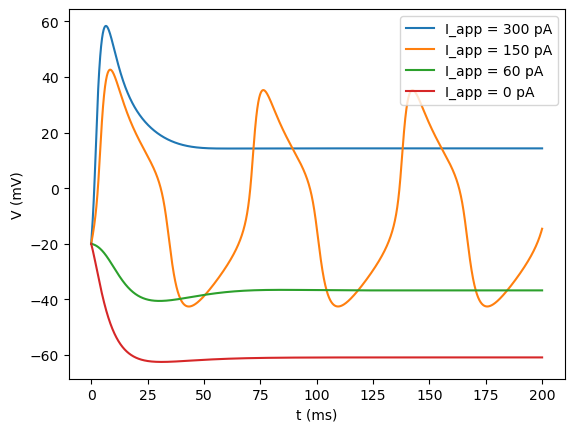

In [66]:
#from Function_bank import Morris_Lecar
#all my functions are well documented in the function_bank.py file
def Morris_Lecar(t, x, I_app=300): # My function import doesn't seem to work so I just redefined the function here #help
    V,w=x
    
    m_inf = 0.5*(1 + np.tanh((V - v1)/v2))
    w_inf = 0.5*(1 + np.tanh((V - v3)/v4))
    tau = 1/np.cosh((V - v3)/(2*v4))

    
    dxdt = [
        (- g_Ca * m_inf * (V - V_Ca) - g_K * w * ( V - V_K) - g_L *(V - V_L) + I_app)/C,
        
        phi * (w_inf - w)/ tau
    ]
    
    return dxdt


fig, ax = plt.subplots()

I_app = [300, 150, 60, 0]

for i in I_app:
    sol=solve_ivp(Morris_Lecar, t_span=[0, 200], y0 =[-20, 0.1], args=(i,), max_step = 0.05)
    ax.plot(sol.t[:], sol.y[0,:], label = f"I_app = {i} pA")

plt.xlabel("t (ms)")
plt.ylabel("V (mV)")
plt.legend()
plt.show()

From the above graph, it is apparent that for $I_app = {0, 60, 300} pA$, the system reaches a stable fixed point. However, for $I_app = 150 pA$ the system is on a limit cycle.

To further visualise the stable limit cycle, the below plot shows a few trajectories through the phase space.

Let's look at the phase portrait to see the behaviour of the limit cycle more clearly.

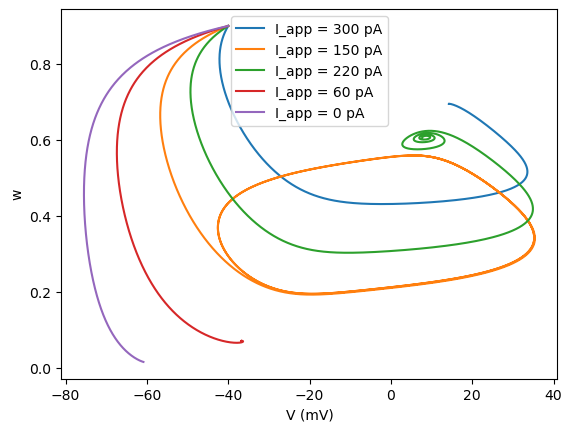

In [67]:
fig, ax = plt.subplots()

I_app = [300, 150, 220, 60, 0]

for i in I_app:
    sol=solve_ivp(Morris_Lecar, t_span=[0, 200], y0 =[-40, 0.9], args=(i,), max_step = 0.05)
    ax.plot(sol.y[0,:], sol.y[1, :], label = f"I_app = {i} pA")

plt.xlabel("V (mV)")
plt.ylabel("w")
plt.legend()
plt.show()

The plot above shows 5 trajectories through phase space using different $I_{app}$ values, only certain values of $I_{app}$ result in a limit cycle, whereas the limit cycle disappears for low and high values of $I_{app}$ to form a stable focus.

Therefore, there is a region where the stable focus turns into an unstable focus inside a stable limit cycle.

Let's look at the phase portrait to see the behaviour of the limit cycle more clearly.

## Phase portrait

<>:51: SyntaxWarning: invalid escape sequence '\d'
<>:51: SyntaxWarning: invalid escape sequence '\d'
C:\Users\adam\AppData\Local\Temp\ipykernel_34452\3865308683.py:51: SyntaxWarning: invalid escape sequence '\d'
  ax.plot(V, Vdot, label= "$\dot{V} = 0$; I_app = 150pA")


Text(0, 0.5, 'w')

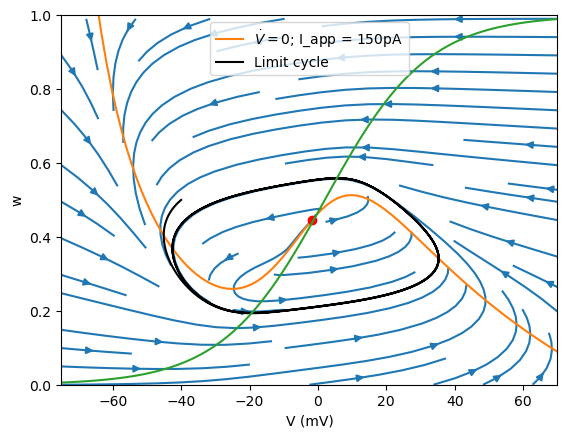

In [68]:
#making the phase portrait

I_app =150
V = np.arange(-75, 75, 5)
w = np.arange(0, 1, 0.01)

VV, ww = np.meshgrid(V, w)

m_inf = 0.5*(1 + np.tanh((VV - v1)/v2))
w_inf = 0.5*(1 + np.tanh((VV - v3)/v4))
tau = 1/np.cosh((VV - v3)/(2*v4))

dVdt = (- g_Ca * m_inf * (VV - V_Ca) - g_K * ww * ( VV - V_K) - g_L *(VV - V_L) + I_app)/C
dwdt = phi * (w_inf - ww)/ tau

fig, ax = plt.subplots()


ax.streamplot(V, w, dVdt, dwdt, density=0.7)

#from Morris_Lecar import Vdotzero
#from Morris_Lecar import wdotzero # function import isn't working somehow, I'll try to fix it for the real thing

def Vdotzero(V, I_app=300):
    
    
    m_inf = 0.5*(1 + np.tanh((V - v1)/v2))
    
    tau = 1/np.cosh((V - v3)/(2*v4))

    
    w= ( g_Ca * m_inf * (V - V_Ca) +g_L *(V - V_L) - I_app)/(- g_K * ( V - V_K))
        
    
    return w


def wdotzero(V):
    w_inf = 0.5*(1 + np.tanh((V - v3)/v4))
    return w_inf


V = np.linspace(-75, 70, 100)

wdot0 = wdotzero(V)

I_app =150


Vdot= Vdotzero(V, I_app)
ax.plot(V, Vdot, label= "$\dot{V} = 0$; I_app = 150pA")
idx = np.argwhere(np.diff(np.sign(Vdot - wdot0))).flatten()
ax.plot(V[idx], Vdot[idx], 'ro')

sol=solve_ivp(Morris_Lecar, t_span=[0, 200], y0 =[-40, 0.5], args=(I_app,), max_step = 0.05)
ax.plot(sol.y[0,:], sol.y[1, :], "k", label = f"Limit cycle")



ax.plot(V, wdot0)
ax.legend()
plt.ylim(top = 1)
plt.xlabel("V (mV)")
plt.ylabel("w")



The Figure above shows a Phase portrait of the Morris-Lecar system, $I_{app}=150 pA$ was used when generating this image. The orange line shows the vertical nullcline $\dot{V} = 0$ for $I_{app}=150 pA$, and the green line shows the horizontal nullcline $\dot{w} = 0$. Their intersection point (red) shows the fixed point. The black line shows the limit cycle.

From the figure above alone, there is a single unstable fixed point in this system located at $V=0$. This unstable fixed apears to be an unstable focus which reaches to a stable limit cycle. Further analysis of the eigenvalues of this system is needed to classify this fixed point.

## Nullclines plot

The stability and location of the fixed point changes depending on the applied current. To visualise this, we can plot multiple vertical nullclines on the same plot.

Text(0, 0.5, 'w')

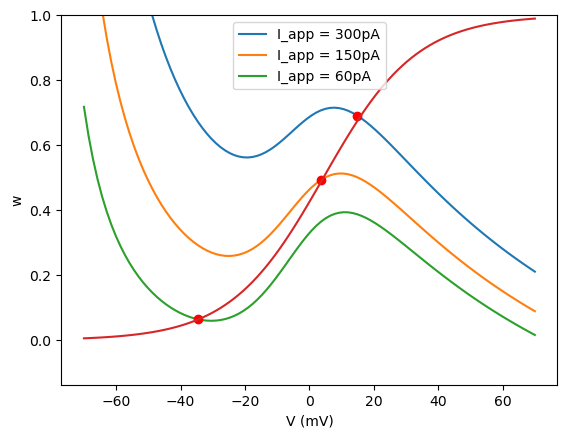

In [69]:
V_lin = np.linspace(-70, 70, 100)

wdot0 = wdotzero(V)

I_app = [300, 150, 60]


fig, ax = plt.subplots()

for i in I_app:
    Vdot0= Vdotzero(V_lin, I_app=i)
    ax.plot(V_lin, Vdot0, label= f"I_app = {i}pA")
    idx = np.argwhere(np.diff(np.sign(Vdot0 - wdot0))).flatten()
    ax.plot(V_lin[idx], Vdot0[idx], 'ro')



ax.plot(V_lin, wdot0)
ax.legend()
plt.ylim(top = 1)
plt.xlabel("V (mV)")
plt.ylabel("w")


## Bifurcation diagram

To show the stability of the fixed point as $I_{app}$ varies, I plotted the bifurcation diagram below. 


To find the point at which the fixed point goes from stable to unstable and the limit cycle appears, I have to linearise the system and find its eigenvalues. The point at which the real part of the eigenvalue goes from negative to positive is the point at which the fixed point turns from stable to unstable and when the limit cycle appears.

In [70]:
#from Function_bank import ML_fsolve
def ML_fsolve(x, I_app=300):
    V, w = x

    
    m_inf = 0.5*(1 + np.tanh((V - v1)/v2))
    w_inf = 0.5*(1 + np.tanh((V - v3)/v4))
    tau = 1/np.cosh((V - v3)/(2*v4))

    
    dxdt = [
        (- g_Ca * m_inf * (V - V_Ca) - g_K * w * ( V - V_K) - g_L *(V - V_L) + I_app)/C,
        
        phi * (w_inf - w)/ tau
    ]
    
    return dxdt




length = 300
I_app = np.linspace(0, 300, length)
V = np.zeros(length)
w = np.zeros(length)

for i in range(len(I_app)):
    sol = fsolve(ML_fsolve, [1,1], args=(I_app[i],))
    V[i], w[i] = sol
    
    


## Plotting bifurcation diagram

What we are observing is a Hopf bifurcation, the fixed point remains, it only changes from stable to unstable due to the change of the sign in the real part of the eigenvalue of the Jacobian.

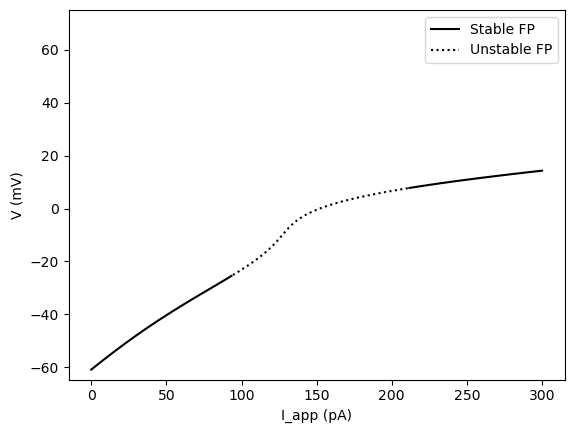

The change from stable to unstable fixed point happens roughly at (94.31438127090301, -25.11128886310555)
The change from unstable to stable fixed point happens roughly at (211.7056856187291, 7.772139732829468)
An example of eigenvalues: [-0.13648842+0.11652587j -0.13648842-0.11652587j]


In [78]:
stability = np.zeros(length)


for i in range(length):
    J=optimize.approx_fprime([V[i], w[i]], ML_fsolve)

    eigenvalues, eigenvectors = LA.eig(J)
    
    if np.real(eigenvalues[0])>=0:
        stability[i] = 1


index_change = np.where(stability == 1)

index_array = index_change[0]

split_I_app = np.split(I_app, [index_array[0], index_array[-1]])
split_V = np.split(V, [index_array[0], index_array[-1]])



fig, ax = plt.subplots()

ax.plot(split_I_app[0], split_V[0],"k", label= "Stable FP")
ax.plot(split_I_app[1], split_V[1], ":k", label="Unstable FP")
ax.plot(split_I_app[2], split_V[2], "k")
ax.legend()
plt.xlabel("I_app (pA)")
plt.ylabel("V (mV)")


plt.ylim(top = 75)
plt.show()

print(f"The change from stable to unstable fixed point happens roughly at ({I_app[index_array[0]]}, {V[index_array[0]]})")
print(f"The change from unstable to stable fixed point happens roughly at ({I_app[index_array[-1]]}, {V[index_array[-1]]})")
print(f"An example of eigenvalues: {eigenvalues}")

From the data, we also have a quite precise location of where the Hopf bifurcations are located, seen above. I do not know how to precisely find the limit cycle, one idea I had was to find the highest and lowest values from the V vs. time plot for different values of $I_{app}$ between $I_{app} \in [94, 222]$. I included the outer boundary because my spacing of $I_{app}$ was roughly 1 pA so the there's a $\pm 1 pA$ uncertainty in the above $I_{app}$ coordinates.




As seen above the eigenvalues for $I_{app} = 300pA$. We have two distinct complex eigenvalues, their real part is negative which means the fixed point is a stable focus. In the dashed-line region, we still have two distinct complex eigenvalues, but their real part is positive, which means the fixed point is an unstable focus. At the same time, we see an appearance of a stable limit cycle, meaning we have a Hopf bifurcation.